##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [52]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt2
import seaborn as sns
import numpy as np

In [53]:
orig_df = pd.read_csv('/content/sample_data/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [54]:
df = pd.read_csv('/content/sample_data/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [55]:


df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [56]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [57]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [58]:
#print a few rows of the values in the dataframe df
df.head(15)

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0
5,-115.132162,36.100841,5,1,3,4,1
6,-115.176012,36.194067,1,1,4,5,2
7,-115.194061,36.135213,3,1,4,3,1
8,-115.069716,36.191304,0,1,5,6,0
9,-115.309341,36.074367,6,1,6,1,0


#Explain what each column of data means.

1. X and Y: These are likely geographical coordinates, often used in mapping and location-based systems. X typically represents the horizontal position (longitude), and Y represents the vertical position (latitude) on a map. These coordinates are used to pinpoint the exact locations where incidents or events have been reported.

2. Area_Command: This is a categorical variable that likely represents different administrative or geographical areas or jurisdictions within a larger region or city. It's used to categorize and group incidents based on where they occurred. This can be helpful for law enforcement agencies and researchers to analyze and manage data from specific areas.

3. NIBRSOffenseCode: NIBRS stands for the National Incident-Based Reporting System, which is a standardized reporting system for crime data. NIBRSOffenseCode is a code that categorizes the type of offense that was reported in a specific incident. These codes help in classifying and organizing various criminal activities, making it easier to analyze crime trends and statistics.

4. DayOfWeek: This variable represents the specific day of the week when the incident was reported. It's a valuable piece of information for understanding patterns and trends related to when different types of incidents occur. For example, it can help identify if certain offenses are more common on weekends or weekdays.

5. Time: Time indicates the hour when the incident was reported. Knowing the time of an incident can be crucial for law enforcement agencies to allocate resources effectively. It can also provide insights into whether there are specific times of the day when certain offenses are more likely to happen.

6. VictimCount: This numeric variable signifies the count of victims involved in the incident. It helps in understanding the scale and severity of an incident. For instance, a higher victim count may indicate a more significant event or a crime with multiple victims, which could have different implications for law enforcement and public safety efforts.


#Identify the input and target variables
Input Variables (Features): X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time

Target Variable: We want to predict the number of victims, then VictimCount would be the target variable.

In [59]:
# Calculating the range of values (min and max) in each column
ranges = df.agg(['min', 'max']).T

# Displaying the ranges
ranges

,min,max
X,-116.000000,-114.62557
Y,35.068419,37.00000
Area_Command,0.000000,11.00000
NIBRSOffenseCode,0.000000,2.00000
DayOfWeek,0.000000,6.00000
Time,0.000000,23.00000
VictimCount,0.000000,6.00000


#What is the range of values in each column? Do you need to scale, shift or normalize your data?
Below are the ranges of values for each column in the simulated DataFrame:


X : -116 to -114.62

Y : 35.07 to 37

Area_command : 0 to 11

NIBRSOffenseCode : 0 to 2

DayOfWeek : 0 to 6

Time : 0 to 23

VictimCount : 0 to 6


For X, Y; These are spatial coordinates. While they are not on vastly different scales, normalizing them could make the training process more stable and faster in some machine learning algorithms.

For Area_command,NIBRSOffenseCode,DayOfWeek; they could be one-hot encoded, which will create a binary column for each category/label.

For Time, we can divide the time into bins (morning, afternoon, evening, night) or normalize it to have values between 0 and 1.

For VictimCount, Since this variable might be the target variable, scaling might not be necessary. However, if it's used as a feature, normalizing it might be helpful to bring it to a similar scale as other features.





## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [60]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx]), torch.tensor(self.labels[idx])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['VictimCount']),
                                                    df['VictimCount'],
                                                    test_size=0.2, random_state=42)

# Create Dataset objects
train_dataset = CustomDataset(X_train.values, y_train.values)
test_dataset = CustomDataset(X_test.values, y_test.values)

# Create DataLoader objects
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify the shape of the batched data
for i, (inputs, targets) in enumerate(train_dataloader):
    print(f"Batch {i+1} - Inputs Shape: {inputs.shape}, Targets Shape: {targets.shape}")


Batch 1 - Inputs Shape: torch.Size([32, 6]), Targets Shape: torch.Size([32])
Batch 2 - Inputs Shape: torch.Size([32, 6]), Targets Shape: torch.Size([32])
Batch 3 - Inputs Shape: torch.Size([32, 6]), Targets Shape: torch.Size([32])
Batch 4 - Inputs Shape: torch.Size([32, 6]), Targets Shape: torch.Size([32])
Batch 5 - Inputs Shape: torch.Size([32, 6]), Targets Shape: torch.Size([32])
Batch 6 - Inputs Shape: torch.Size([32, 6]), Targets Shape: torch.Size([32])
Batch 7 - Inputs Shape: torch.Size([28, 6]), Targets Shape: torch.Size([28])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

1) Define the proper loss function for this task
--
Mean Squared Error (MSE) Loss: Suitable for regression tasks. It measures the average of the squares of the errors between the true and predicted values.

2)  What should the size of the predicted output be?
--
The output should be a single real number representing the predicted VictimCount.

3)  Explain your choice of architecture, including how many layers you will be using
--
Layers:

Input Layer: Size equal to the number of features.

Hidden Layers: One or two hidden layers.

Output Layer: One neuron to output the predicted VictimCount.

Activation Functions:

ReLU: For hidden layers, as it helps with the vanishing gradient problem.

No activation: For the output layer, as we want a raw score for regression.

4)  Define an optimizer for training this model, choose a proper learning rate
--
Optimizer: Adam, a popular choice due to adaptive learning rates.

Learning Rate: Starting with 0.001. Will adjust based on training performance.


5) Write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
--
Implementing the training loop with forward and backward passes.
Updating weights with the optimizer.
Training over multiple epochs and calculating MSE on test data after each epoch.

6) Write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.



7) is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [28]:
#Approach 1
import torch
import torch.nn as nn
import torch.optim as optim


class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class RegressionModelTanh(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionModelTanh, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh(out)
        out = self.fc2(out)
        return out

class RegressionModelSigmoid(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionModelSigmoid, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out


# Hyperparameters

learning_rate =0.0001
hidden_size = 64
epochs = 150


# Initialize the model, loss function, and optimizer
model = RegressionModel(X_train.shape[1], hidden_size) #90.2

# For ReLU
#model = RegressionModelReLU(X_train.shape[1], hidden_size)  #96.1%

# For Tanh
#model = RegressionModelTanh(X_train.shape[1], hidden_size) #93.4%

# For Sigmoid
#model = RegressionModelSigmoid(X_train.shape[1], hidden_size) #92.33%


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validation Loop
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.float().unsqueeze(1))
            test_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Test MSE: {test_loss/len(test_dataloader)}")


Epoch [1/150], Test MSE: 73.47274780273438
Epoch [2/150], Test MSE: 61.76985740661621
Epoch [3/150], Test MSE: 51.35099983215332
Epoch [4/150], Test MSE: 42.22845458984375
Epoch [5/150], Test MSE: 34.314640045166016
Epoch [6/150], Test MSE: 27.614559173583984
Epoch [7/150], Test MSE: 21.96352195739746
Epoch [8/150], Test MSE: 17.32012367248535
Epoch [9/150], Test MSE: 13.50349473953247
Epoch [10/150], Test MSE: 10.458015441894531
Epoch [11/150], Test MSE: 8.037064552307129
Epoch [12/150], Test MSE: 6.1537580490112305
Epoch [13/150], Test MSE: 4.714637041091919
Epoch [14/150], Test MSE: 3.6312623023986816
Epoch [15/150], Test MSE: 2.8249822854995728
Epoch [16/150], Test MSE: 2.24321448802948
Epoch [17/150], Test MSE: 1.8257979154586792
Epoch [18/150], Test MSE: 1.5342223048210144
Epoch [19/150], Test MSE: 1.3363142609596252
Epoch [20/150], Test MSE: 1.206408441066742
Epoch [21/150], Test MSE: 1.1220036745071411
Epoch [22/150], Test MSE: 1.0657006800174713
Epoch [23/150], Test MSE: 1.031

In [95]:
#Approach 2
import torch
import torch.nn as nn
import torch.optim as optim


class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hyperparameters

learning_rate =0.005
hidden_size = 16
epochs = 100


# Initialize the model, loss function, and optimizer
model = RegressionModel(X_train.shape[1], hidden_size) #90.2


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validation Loop
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.float().unsqueeze(1))
            test_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Test MSE: {test_loss/len(test_dataloader)}")


Epoch [1/100], Test MSE: 163.08665466308594
Epoch [2/100], Test MSE: 31.937020301818848
Epoch [3/100], Test MSE: 1.376923680305481
Epoch [4/100], Test MSE: 11.671630382537842
Epoch [5/100], Test MSE: 5.850774765014648
Epoch [6/100], Test MSE: 1.1468323767185211
Epoch [7/100], Test MSE: 1.3742239475250244
Epoch [8/100], Test MSE: 1.4937663674354553
Epoch [9/100], Test MSE: 1.0829662084579468
Epoch [10/100], Test MSE: 0.9841726720333099
Epoch [11/100], Test MSE: 1.053721010684967
Epoch [12/100], Test MSE: 1.0095288455486298
Epoch [13/100], Test MSE: 0.9607864022254944
Epoch [14/100], Test MSE: 0.9520712196826935
Epoch [15/100], Test MSE: 0.9481621086597443
Epoch [16/100], Test MSE: 0.9451486170291901
Epoch [17/100], Test MSE: 0.9436311721801758
Epoch [18/100], Test MSE: 0.9393385052680969
Epoch [19/100], Test MSE: 0.9362813234329224
Epoch [20/100], Test MSE: 0.9316270649433136
Epoch [21/100], Test MSE: 0.927518367767334
Epoch [22/100], Test MSE: 0.9251222610473633
Epoch [23/100], Test MS

We got the MSE loss close to 0.91


## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

How would you find the number of classes on the output data?
--
We can find the number of classes by identifying the unique values in the target variable VictimCount.

How is the architecture different?
--
The last layer should have neurons equal to the number of classes.
Softmax activation should be applied at the output layer to get probabilities of each class.


How is the loss function different?
--
Cross-Entropy Loss should be used for classification tasks as it measures the performance of a classification model whose output is a probability value between 0 and 1. But for regression we use Mean squared error as the loss


Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
--



Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?
--

In [16]:
#Approach 1
import torch
import torch.nn as nn
import torch.optim as optim

# Finding the number of classes
num_classes = len(df['VictimCount'].unique())

# Define the Neural Network architecture for Classification
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hyperparameters
learning_rate = 0.001
hidden_size = 128
epochs = 10

# Initialize the model, loss function, and optimizer
model = ClassificationModel(X_train.shape[1], hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()

    # Validation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {accuracy}%")


Epoch [1/10], Accuracy: 56.36363636363637%
Epoch [2/10], Accuracy: 49.09090909090909%
Epoch [3/10], Accuracy: 60.0%
Epoch [4/10], Accuracy: 43.63636363636363%
Epoch [5/10], Accuracy: 54.54545454545455%
Epoch [6/10], Accuracy: 41.81818181818182%
Epoch [7/10], Accuracy: 54.54545454545455%
Epoch [8/10], Accuracy: 49.09090909090909%
Epoch [9/10], Accuracy: 34.54545454545455%
Epoch [10/10], Accuracy: 54.54545454545455%


In [17]:
#Approach 2 - by tweaking the hyperparameters
import torch
import torch.nn as nn
import torch.optim as optim

# Finding the number of classes
num_classes = len(df['VictimCount'].unique())

# Define the Neural Network architecture for Classification
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hyperparameters
learning_rate = 0.01
hidden_size = 32
epochs = 100

# Initialize the model, loss function, and optimizer
model = ClassificationModel(X_train.shape[1], hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()

    # Validation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {accuracy}%")


Epoch [1/100], Accuracy: 54.54545454545455%
Epoch [2/100], Accuracy: 29.09090909090909%
Epoch [3/100], Accuracy: 30.90909090909091%
Epoch [4/100], Accuracy: 30.90909090909091%
Epoch [5/100], Accuracy: 54.54545454545455%
Epoch [6/100], Accuracy: 54.54545454545455%
Epoch [7/100], Accuracy: 54.54545454545455%
Epoch [8/100], Accuracy: 54.54545454545455%
Epoch [9/100], Accuracy: 54.54545454545455%
Epoch [10/100], Accuracy: 54.54545454545455%
Epoch [11/100], Accuracy: 38.18181818181818%
Epoch [12/100], Accuracy: 27.272727272727273%
Epoch [13/100], Accuracy: 30.90909090909091%
Epoch [14/100], Accuracy: 50.90909090909091%
Epoch [15/100], Accuracy: 52.72727272727273%
Epoch [16/100], Accuracy: 54.54545454545455%
Epoch [17/100], Accuracy: 54.54545454545455%
Epoch [18/100], Accuracy: 54.54545454545455%
Epoch [19/100], Accuracy: 54.54545454545455%
Epoch [20/100], Accuracy: 52.72727272727273%
Epoch [21/100], Accuracy: 54.54545454545455%
Epoch [22/100], Accuracy: 54.54545454545455%
Epoch [23/100], Ac

In [20]:
#Approach 3 - by tweaking the hyperparameters
import torch
import torch.nn as nn
import torch.optim as optim

# Finding the number of classes
num_classes = len(df['VictimCount'].unique())

# Define the Neural Network architecture for Classification
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hyperparameters
learning_rate = 0.0001
hidden_size = 64
epochs = 250

# Initialize the model, loss function, and optimizer
model = ClassificationModel(X_train.shape[1], hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()

    # Validation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {accuracy}%")


Epoch [1/250], Accuracy: 41.81818181818182%
Epoch [2/250], Accuracy: 49.09090909090909%
Epoch [3/250], Accuracy: 50.90909090909091%
Epoch [4/250], Accuracy: 49.09090909090909%
Epoch [5/250], Accuracy: 49.09090909090909%
Epoch [6/250], Accuracy: 50.90909090909091%
Epoch [7/250], Accuracy: 54.54545454545455%
Epoch [8/250], Accuracy: 54.54545454545455%
Epoch [9/250], Accuracy: 54.54545454545455%
Epoch [10/250], Accuracy: 54.54545454545455%
Epoch [11/250], Accuracy: 54.54545454545455%
Epoch [12/250], Accuracy: 54.54545454545455%
Epoch [13/250], Accuracy: 54.54545454545455%
Epoch [14/250], Accuracy: 54.54545454545455%
Epoch [15/250], Accuracy: 54.54545454545455%
Epoch [16/250], Accuracy: 54.54545454545455%
Epoch [17/250], Accuracy: 54.54545454545455%
Epoch [18/250], Accuracy: 54.54545454545455%
Epoch [19/250], Accuracy: 54.54545454545455%
Epoch [20/250], Accuracy: 54.54545454545455%
Epoch [21/250], Accuracy: 54.54545454545455%
Epoch [22/250], Accuracy: 54.54545454545455%
Epoch [23/250], Acc

In [19]:
#Approach 4 - by tweaking the hyperparameters
import torch
import torch.nn as nn
import torch.optim as optim

# Finding the number of classes
num_classes = len(df['VictimCount'].unique())

# Define the Neural Network architecture for Classification
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hyperparameters
learning_rate = 0.001
hidden_size = 64
epochs = 10

# Initialize the model, loss function, and optimizer
model = ClassificationModel(X_train.shape[1], hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()

    # Validation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {accuracy}%")


Epoch [1/10], Accuracy: 23.636363636363637%
Epoch [2/10], Accuracy: 54.54545454545455%
Epoch [3/10], Accuracy: 54.54545454545455%
Epoch [4/10], Accuracy: 47.27272727272727%
Epoch [5/10], Accuracy: 58.18181818181818%
Epoch [6/10], Accuracy: 58.18181818181818%
Epoch [7/10], Accuracy: 43.63636363636363%
Epoch [8/10], Accuracy: 56.36363636363637%
Epoch [9/10], Accuracy: 47.27272727272727%
Epoch [10/10], Accuracy: 56.36363636363637%


The maximum accuracy achieved in classification is 56.36%

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.


Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
--
Working on tasks 3 and 4 was insightful as it involved dealing with both regression and classification aspects of a neural network on the same dataset. In task 3, predicting the number of crime victims as a real number allowed for continuous output, and the Mean Squared Error (MSE) loss function was quite fitting. However, in task 4, predicting the number of victims as a class label made the problem discrete and categorical, requiring modifications like changing the architecture of the neural network to have output neurons equal to the number of classes and using the Cross-Entropy Loss function.

Comparing the results depends on various factors like model architecture, hyperparameters, and the nature of the data. Generally, classification might work better if the VictimCount varies discretely and has a reasonable number of unique values (classes), as it allows the model to generalize better over the classes.

Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.
--
Given below

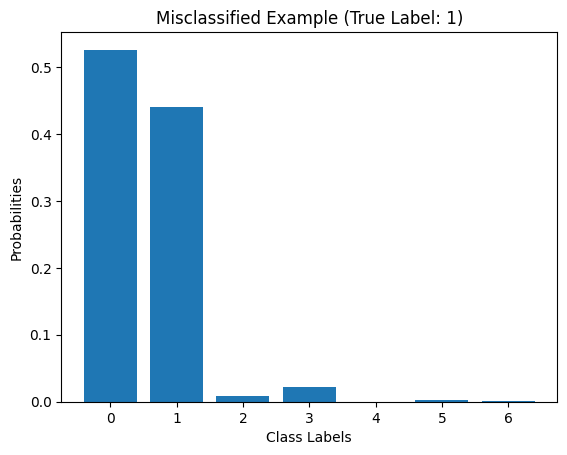

In [12]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()  # Set the model to evaluation mode

# Finding a misclassified example
for inputs, targets in test_dataloader:
    outputs = model(inputs.float())
    _, predicted = torch.max(outputs.data, 1)
    wrong_idx = (predicted != targets).nonzero().squeeze()  # Index where prediction is wrong
    if wrong_idx.numel() > 0:  # If there's a misclassification
        wrong_idx = wrong_idx[0]  # Taking the first misclassified example
        probs = nn.functional.softmax(outputs[wrong_idx], dim=0)  # Calculating probabilities
        true_label = targets[wrong_idx].item()
        break

# Plotting the probabilities in a bar chart
plt.bar(range(num_classes), probs.detach().numpy())
plt.xlabel('Class Labels')
plt.ylabel('Probabilities')
plt.title(f'Misclassified Example (True Label: {true_label})')
plt.show()


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


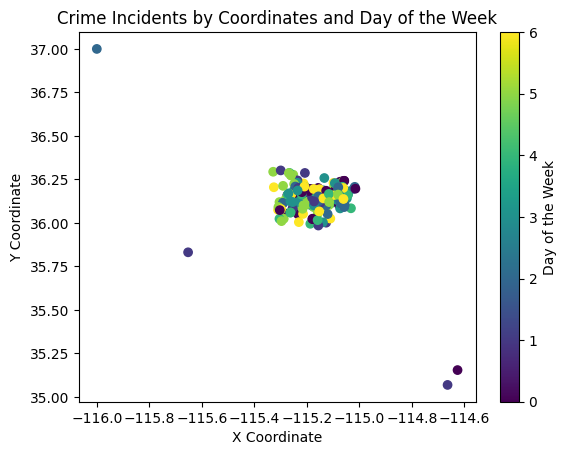

In [13]:
#Plot the crime incidents as a scatter plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?


import matplotlib.pyplot as plt

# Scatter plot of crime incidents by coordinates, colored by day of the week
colors = df['DayOfWeek']
plt.scatter(df['X'], df['Y'], c=colors, cmap='viridis')
plt.colorbar(label='Day of the Week')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Crime Incidents by Coordinates and Day of the Week')
plt.show()


We can observe a pattern here where most of the datapoints lie in the range of (-115.2,36.25). Also we can observe that most number of accidents occur in the midweek from wednesday to friday.


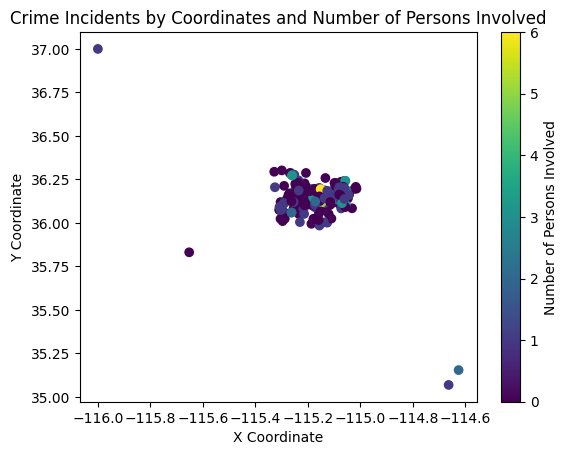

In [14]:
# Scatter plot of crime incidents by coordinates, colored by the number of persons involved


colors = df['VictimCount']
plt.scatter(df['X'], df['Y'], c=colors, cmap='viridis')
plt.colorbar(label='Number of Persons Involved')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Crime Incidents by Coordinates and Number of Persons Involved')
plt.show()


We can observe a pattern here in the graph where the number of people involved are in the range of 1 to 2.


In [15]:

# Mapping numerical days to actual names of the days
day_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Applying the mapping to the 'DayOfWeek' column
df['DayName'] = df['DayOfWeek'].map(day_mapping)

# Counting the number of crimes reported by day of the week and sorting by the day order
crime_counts_by_day = df['DayName'].value_counts().reindex(list(day_mapping.values()))

# Printing the sorted results
print(crime_counts_by_day)


Monday       40
Tuesday      37
Wednesday    32
Thursday     44
Friday       51
Saturday     43
Sunday       28
Name: DayName, dtype: int64


The most frequent days for crimes are Friday, Thursday, Saturday

Regerences: Google, ChatGPT, Official Python Documentation